# Right Whale Recognition

Training classifier for Kaggle's [Right Whale Recognition](https://www.kaggle.com/c/noaa-right-whale-recognition) competition.

## Imports and Extensions

All packages and extensions used in the notebook are gathered into this section.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [5]:
import os
import shutil
from pathlib import Path
from os import makedirs, listdir
from collections import Counter, namedtuple
from os.path import join, exists, expanduser

import cv2
import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.externals import joblib
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, StandardScaler

from swissknife.notebook import print_list
from swissknife.config import notebook_logger
from swissknife.utils import split_dataset_files, calculate_layout
from swissknife.kaggle.datasets import KaggleClassifiedImagesSource, KaggleTestImagesIterator, read_labels

# Deep learning and GPU setup
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

# Adjust amount of available GPU memory if required
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
set_session(tf.Session(config=config))

# Other keras imports
from keras.preprocessing.image import random_rotation, random_shift, flip_axis

Using TensorFlow backend.


In [6]:
# competition's data paths
from basedir import (
    COMPETITION_DATA, PREPARED_DATA, IMAGES_PATH,
    LABELS_PATH, TEST_DATA, TRAIN_DATA, VALID_DATA,
    EXTENDED_LABELS)

In [7]:
log = notebook_logger()

In [8]:
RANDOM_STATE = 1

In [49]:
!cat $LABELS_PATH | head -n 5

Image,whaleID
w_7812.jpg,whale_48813
w_4598.jpg,whale_09913
w_3828.jpg,whale_45062
w_8734.jpg,whale_74162
cat: write error: Broken pipe


## Competition Dataset Preparation

Original competition's data is provided as a single folder with whales's images and a CSV file with training labels. Before we can start analysis it is worth to organize files in more suitable way. First of all, we're going to separate _labelled_ (training) files from _un-labelled_ (testing) ones. Second, we're going to keep a small part of training data aside as a _validation_ subset. 

One of specific features of analysed dataset is that it contains a few classes (whale IDs) with only **a single sample** in them:

In [50]:
with open(LABELS_PATH) as lines:
    _ = next(lines)  # skip header
    targets = [line.strip().split(',')[-1] for line in lines]
counts = Counter(targets)
singletons = [target for target, count in counts.items() if count <= 1]
print_list(singletons)

whale_54796, whale_64299, whale_21655, whale_56281, whale_86081, whale_04480, whale_22212, whale_88085, whale_88226, whale_90966, whale_40483, whale_51332, whale_66539, whale_77984, whale_88432, whale_45294, whale_54497, whale_34513, whale_81915, whale_22848, whale_89271, whale_08729, whale_05140, whale_51114



Therefore, these classes cannot be separated into training and validation data. To overcome this issue, we're going to expand these singletons with augmented images, created by **vertical and horizontal reflections** of original image. Using this apporach we get four instances per class instead of one.

In [51]:
# Uncomment the following command to delete previously prepared folder
# !rm -rf $PREPARED_DATA

> **Note:** Next cell is not idempotent - it is not organizes files again if data was already prepared during previous runs. If there is some reason to invoke this cell again, delete previously prepared folder

In [52]:
EXTENDED_LABELS

'/home/ck/data/kaggle/noaa-right-whale-recognition/prepared/labels.csv'

In [53]:
if not exists(COMPETITION_DATA):
    log.error('Competition dataset wasn\'t downloaded from Kaggle')
    
else:    
    if exists(PREPARED_DATA):
        log.warning('Competition data was already separated into training and validation folders')
        classes = read_labels(filename=EXTENDED_LABELS,
                              class_column='whaleID',
                              id_column='Image')
        
    else:                    
        log.info('Parsing original file with labels')
        classes = read_labels(filename=LABELS_PATH,
                              class_column='whaleID',
                              id_column='Image')    
       
        for path in (PREPARED_DATA, TEST_DATA, TRAIN_DATA):
            log.info('Creating directory: %s', path)
            makedirs(path)

        log.info('Separating labelled and un-labelled data')
        for filename in listdir(IMAGES_PATH):
            file_id, _ = filename.split('.')
            src = join(IMAGES_PATH, filename)
            dst = join(TRAIN_DATA if file_id in classes else TEST_DATA, filename)        
            shutil.copy(src, dst)

        log.info('Expanding classes with single instance')
        counts = Counter(classes.values())    
        for filename in listdir(TRAIN_DATA):
            file_id, _ = filename.split('.')
            class_name = classes[file_id]
            n_samples = counts[class_name]

            if n_samples == 1:
                filepath = join(TRAIN_DATA, filename)
                image = plt.imread(filepath)
                extended = dict(
                    flip0=flip_axis(image, 0),
                    flip1=flip_axis(image, 1),
                    flip01=flip_axis(flip_axis(image, 1), 0))
                for suffix, image in extended.items():
                    new_name = f'{file_id}_{suffix}'
                    new_path = join(TRAIN_DATA, f'{new_name}.jpg')
                    plt.imsave(new_path, image)
                    classes[new_name] = class_name

        log.info('Splitting labelled files into training and validation subsets')
        files = split_dataset_files(dataset_dir=TRAIN_DATA, 
                                    output_dir=PREPARED_DATA,
                                    classes=classes,
                                    random_state=RANDOM_STATE,
                                    rewrite=False,
                                    delete_source=True)

        log.info('Creating new file with labels: %s', EXTENDED_LABELS)
        with open(EXTENDED_LABELS, 'w') as file:
            file.write('Image,whaleID\n')
            for uid, class_name in classes.items():
                file.write('%s.jpg,%s\n' % (uid, class_name))
        
        log.info('Number of training files: %d', len(files['train']))
        log.info('Number of validation files: %d', len(files['valid']))

Competition data was already separated into training and validation folders


## Dataset Analysis

As usual, before we start running machine algorithms on dataset, let's make a brief overview of the dataset. Actually the first step was already done in previous section: it was revealed that there are singleton classes and these classes were extended with additional augmented samples.

Next step is to further investigate distrubution of classes. How many classes there are in total? How many samples they have? Is the dataset well-balanced or not? We can already expect that the dataset has a lot of classes with small amout of samples per each class, but let's verify this claim.

In [54]:
source = KaggleClassifiedImagesSource(classes=classes)

In [55]:
source.n_classes

447

In [15]:
ticks, values, _, bin_labels = source.frequency_histogram(bins=[1, 5, 10, 15, 20, 25])

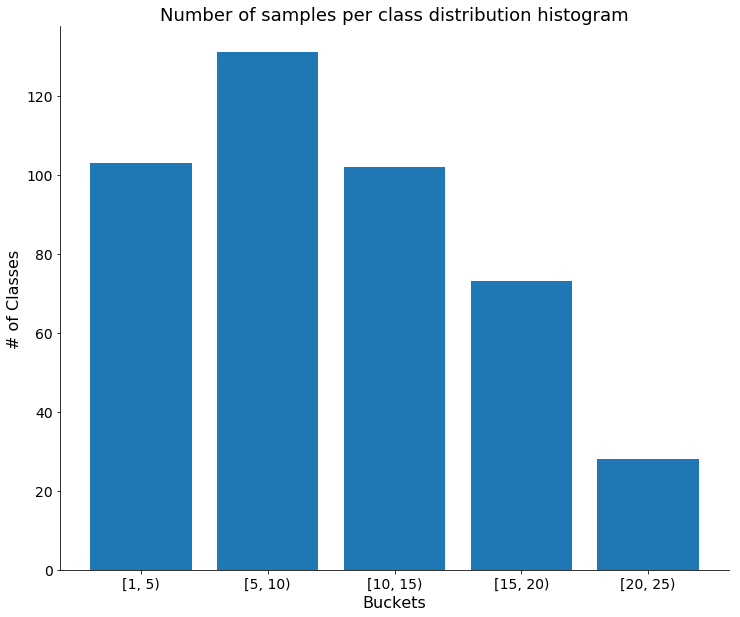

In [16]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(ticks, values)
ax.set_xticks(ticks)
ax.set_yticklabels([int(tick) for tick in ax.get_yticks()], fontsize=14)
ax.set_xticklabels(bin_labels, fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Buckets', fontsize=16)
ax.set_ylabel('# of Classes', fontsize=16)
ax.set_title('Number of samples per class distribution histogram', fontsize=18);

As histogram above shows most classes have from 5 to 10 samples. Approximately 100 classes have less then 4 samples. And there are just a few classes with more then 20 images in them. 

Now let's take a look at dataset images themselves.

In [17]:
def list_files(folder):
    return [join(folder, filename) for filename in listdir(folder)]

In [18]:
def imread(filename, dtype=np.uint8):
    return plt.imread(filename).astype(dtype)

In [19]:
train_files = list_files(TRAIN_DATA)
valid_files = list_files(VALID_DATA)

In [20]:
def read_image(filename, source, dtype=np.uint8):
    """Returns an image and its class using provided filename."""
    
    image = imread(filename, dtype)
    class_name = source.class_name_from_file(filename)
    return image, class_name

In [21]:
def plot_sample(image, title, figsize=(12, 10)):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(image)
    ax.axis('off')
    f.subplots_adjust(top=1.1)
    string = title.title().replace('_', ' ID=')
    f.suptitle(string, fontsize=18)

In [22]:
def show_images(filenames, source, figsize=(20, 16)):
    n = len(filenames)
    f, axes = plt.subplots(*calculate_layout(n, n_cols=2), figsize=figsize)

    for filename, ax in zip(filenames, axes.flatten()):
        image, title = read_image(filename, source)
        title = title.title().replace('_', ' ID=')
        ax.imshow(image)
        ax.set_title(title, fontsize=18)
        ax.axis('off')        
        
    f.subplots_adjust(top=0.8)

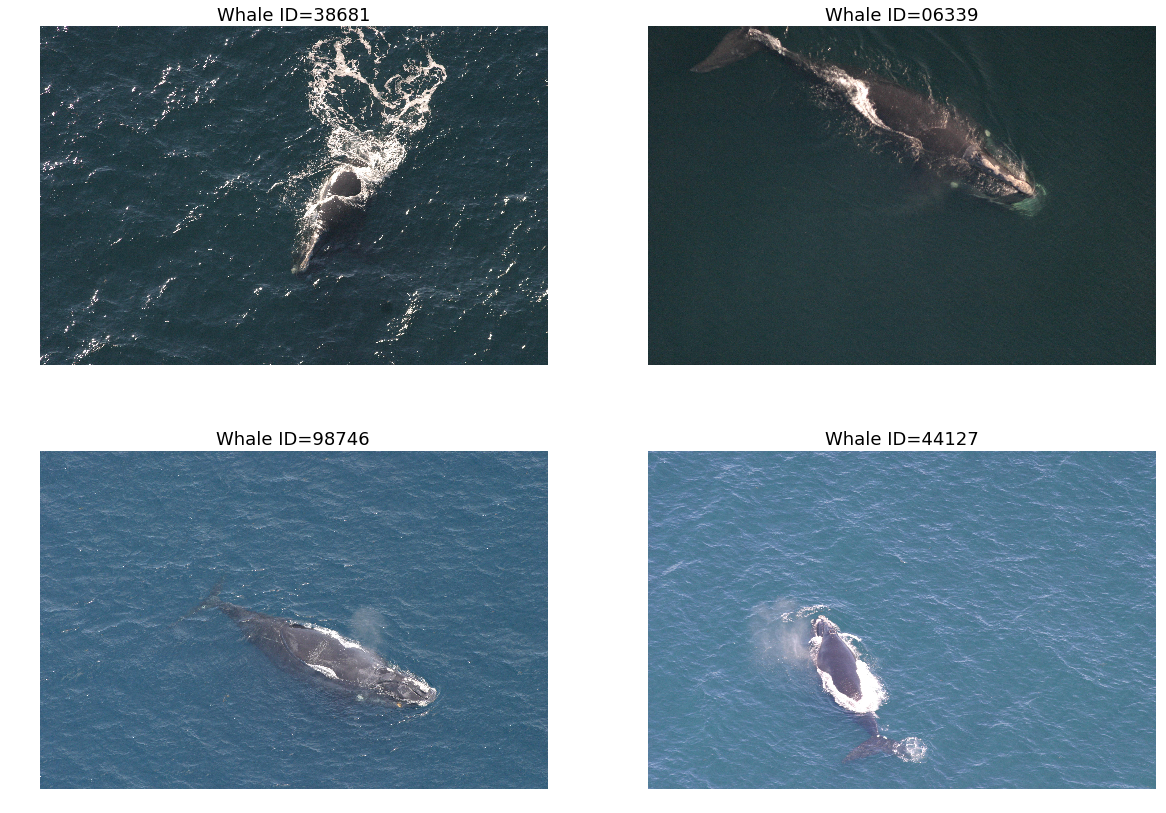

In [23]:
show_images(train_files[20:24], source)

Each whale is photograped from "bird-eye" view. These pictures are not like something which could be found in everyday environment. It seems that blue and green colors are dominant for pictures of this dataset. To verify this assumption, let's plot histograms showing color distributions for training subset: 

In [24]:
def color_histgorams(filenames):
    channels = (0, 1, 2)
    means = [np.zeros(256) for _ in channels]

    for i, filename in enumerate(filenames, 1):
        image = imread(filename)        
        for channel in (0, 1, 2):
            hist = cv2.calcHist([image], [channel], None, [256], [0, 256]).flatten()
            means[channel] = (1./i) * (hist + (i - 1)*means[channel])
            
    return means

In [25]:
r, g, b = color_histgorams(train_files)

In [26]:
def plot_histogram(r, g, b):
    f, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.plot(r, 'r-')
    ax.plot(g, 'g-')
    ax.plot(b, 'b-')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=18)    
    ax.set_yticklabels([], fontsize=18)
    ax.set_yticks([])    
    ax.set_xlabel('RGB Value of Pixel', fontsize=16)
    ax.set_ylabel('Number of Pixels with color', fontsize=16)
    ax.set_title('Training Dataset Colors Histogram', fontsize=18)

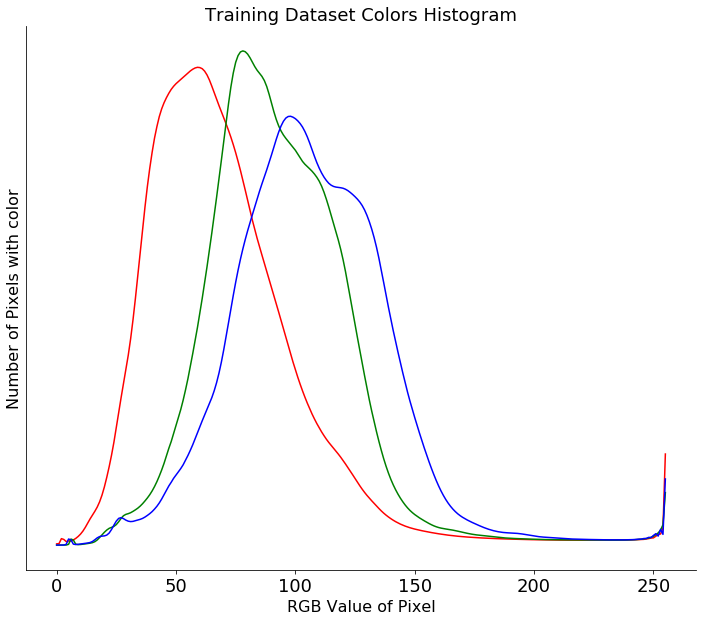

In [27]:
plot_histogram(r, g, b)

As it was expected, red channel is not too intensive, but blue and green are more outstanding. Probably we could take into account this feature of dataset as well and, for example, discard red channel to speed up convolutions when appliying deep learning models.

## Using SGD classifier

In [106]:
def sgd(x_train, y_train, 
        x_valid, y_valid, 
        variance_threshold=0.1, 
        n_estimators=10):    
    
    threshold = VarianceThreshold(variance_threshold)
        
    sgd_classifier = SGDClassifier(
        alpha=1./len(x_train),
        class_weight='balanced',
        loss='log', penalty='elasticnet', 
        fit_intercept=False, tol=0.001, n_jobs=-1)
    
    bagging = BaggingClassifier(
        base_estimator=sgd_classifier,
        bootstrap_features=True, 
        n_estimators=n_estimators,
        n_jobs=-1, max_samples=0.5, max_features=0.5)    
    
    x_thresh = threshold.fit_transform(x_train)
    bagging.fit(x_thresh, y_train)
    train_metrics = build_metrics(bagging, x_thresh, y_train)

    x_thresh = threshold.transform(x_valid)
    valid_metrics = build_metrics(bagging, x_thresh, y_valid)

    return bagging, train_metrics, valid_metrics    


def build_metrics(model, X, y):
    probs = model.predict_proba(X)
    preds = np.argmax(probs, axis=1)
    metrics = dict(
        probs=probs,
        preds=preds,
        loss=log_loss(y, probs, labels=model.classes_),
        accuracy=np.mean(preds == y))
    return namedtuple('Predictions', metrics.keys())(**metrics)    


def create_targets(source, folder):
    """Converts file paths into target labels."""
    
    labels = [
        one_hot.argmax()
        for one_hot in (
            source.identifier_to_label[Path(filename).stem]
            for filename in os.listdir(folder))]
    return np.asarray(labels)

In [49]:
train_labels = create_targets(source, TRAIN_DATA)
valid_labels = create_targets(source, VALID_DATA)

### Features Extraction

Now we're going to use deep learning networks to extact whales features and to run SGD on it.

In [65]:
class FeaturesExtractor:
    """Runs pretrained model without top layers on dataset and saves generated
    bottleneck features onto disk.
    """
    def __init__(self, build_fn, preprocess_fn, source,
                 target_size=(299, 299, 3), batch_size=128,
                 pool='avg'):        
        
        self.build_fn = build_fn
        self.preprocess_fn = preprocess_fn
        self.source = source
        self.target_size = target_size
        self.batch_size = batch_size
        self.model = self.build_fn(weights='imagenet', include_top=False, pooling=pool)
        
    def __call__(self, folder, filename):
        stream = self.source(
            folder=folder, target_size=self.target_size,
            batch_size=self.batch_size, infinite=False)
        
        batches = []
        with tqdm.tqdm(total=stream.steps_per_epoch) as bar:
            for x_batch, y_batch in stream:
                x_preprocessed = self.preprocess_fn(x_batch)
                batch = self.model.predict_on_batch(x_preprocessed)
                batches.append(batch)
                bar.update(1)
                
        all_features = np.vstack(batches)
        np.save(filename, all_features)
        return filename

In [75]:
def extract_features(extractor, folder, filename, size):
    path = extractor(folder, filename)
    features = np.load(path)
    assert len(features) == size
    return path


def extract_train_features(features_extractor, model_name):
    filename = '%s_train_features.npy' % model_name
    return extract_features(features_extractor, TRAIN_DATA, filename, size=3692)


def extract_valid_features(features_extractor, model_name):
    filename = '%s_valid_features.npy' % model_name
    return extract_features(features_extractor, VALID_DATA, filename, size=923)

In [100]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

target_size = (299, 299, 3)

extractor = FeaturesExtractor(
    build_fn=InceptionResNetV2,
    preprocess_fn=preprocess_input,
    target_size=target_size,
    source=source)

In [101]:
extract_train_features(extractor, 'inception')

HBox(children=(IntProgress(value=0, max=29), HTML(value='')))

'inception_train_features.npy'

In [102]:
extract_valid_features(extractor, 'inception')

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

'inception_valid_features.npy'

In [103]:
train_features = np.load('inception_train_features.npy')

In [104]:
valid_features = np.load('inception_valid_features.npy')

In [107]:
model, train, valid = sgd(
    x_train=train_features, 
    y_train=train_labels,
    x_valid=valid_features, 
    y_valid=valid_labels,
    n_estimators=100,
    variance_threshold=0.001)

print(f'Train: loss {train.loss:2.6f} - acc: {train.accuracy:2.2%}')
print(f'Valid: loss {valid.loss:2.6f} - acc: {valid.accuracy:2.2%}')

Train: loss 3.167808 - acc: 63.35%
Valid: loss 5.488443 - acc: 9.64%


## Concatenating Features from Several Extractors

In [1]:
dataset = np.load('all_features.npz')

NameError: name 'np' is not defined

In [2]:
x_train = dataset['x_train'] 
x_valid = dataset['x_valid']
y_train = dataset['y_train']
y_valid = dataset['y_valid']

NameError: name 'dataset' is not defined

In [48]:
sgd_classifier = SGDClassifier(
    alpha=1./len(x_train),
    class_weight='balanced',
    loss='log', penalty='elasticnet',
    fit_intercept=False, tol=0.001, n_jobs=-1)

In [95]:
bagging = BaggingClassifier(
    base_estimator=sgd_classifier,
    bootstrap_features=True, 
    n_estimators=10,
    n_jobs=-1, max_samples=0.8, max_features=1/3.)    

In [96]:
scaler = StandardScaler()

In [97]:
x_scaled = scaler.fit_transform(x_train)

In [98]:
bagging.fit(x_scaled, y_train)

BaggingClassifier(base_estimator=SGDClassifier(alpha=0.00027085590465872155, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=False,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_jobs=-1, penalty='elasticnet', power_t=0.5,
       random_state=None, shuffle=True, tol=0.001, verbose=0,
       warm_start=False),
         bootstrap=True, bootstrap_features=True,
         max_features=0.3333333333333333, max_samples=0.8, n_estimators=10,
         n_jobs=-1, oob_score=False, random_state=None, verbose=0,
         warm_start=False)

In [104]:
from sklearn.externals import joblib
joblib.dump(bagging, 'sgd_bag_100.pkl')

['sgd_bag_100.pkl']

In [99]:
probs = bagging.predict_proba(scaler.transform(x_valid))

/home/ck/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/ck/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/ck/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/ck/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/ck/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/ck/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/ck/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn

In [100]:
preds = probs.argmax(axis=1)

In [101]:
loss = log_loss(y_valid, probs, labels=sgd_classifier.classes_)

In [102]:
accuracy = np.mean(preds == y_valid)

In [103]:
loss

6.11867840204964

## Running Tensorflow-Based SGD Classifier

In [9]:
def schedule(epoch, decay=0.05, init=1.0):
    return init*np.exp(-decay*epoch)

In [10]:
x = list(range(100))
y = [schedule(i) for i in x]

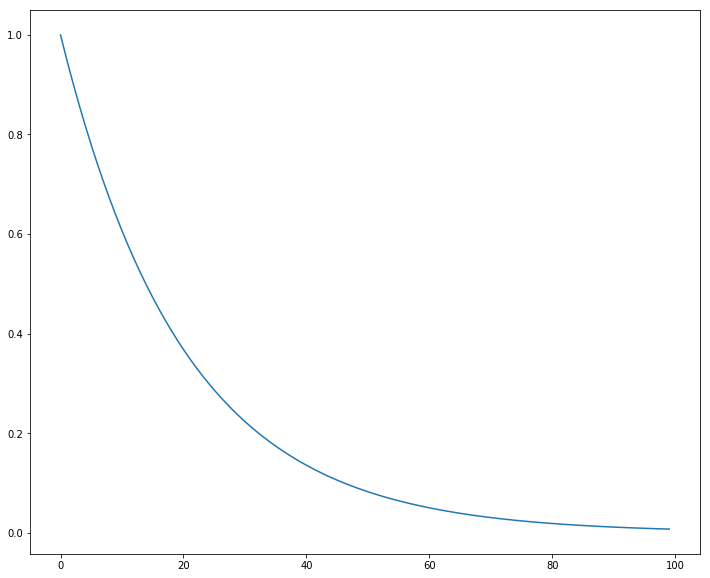

In [11]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(x, y)

In [17]:
import math
from collections import Counter
from sklearn.model_selection import ParameterSampler
from model.sgd import LogisticClassifier
from callbacks import StreamLogger, ExpoDecay, EarlyStopping
from data import get_features

In [13]:
dataset = get_features('all_features.npz')

In [14]:
X, y = dataset['train']

In [15]:
num_features = X.shape[1]
num_classes = dataset['n_classes']

In [16]:
print(f'Features: {num_features}, classes: {num_classes}')

Features: 5632, classes: 447


In [17]:
model = LogisticClassifier(num_features, num_classes, alpha=0.005, l1_ratio=0.15)

In [18]:
model.build()

In [16]:
callbacks = [
    StreamLogger(formatter_config={
        'suppress_metrics': [
            'val_penalized_loss', 'penalized_loss']
    }), 
    ExpoDecay(decay=0.002)
]

In [18]:
h = model.fit(X=X, y=y,
              batch_size=512,
              epochs=10,
              lr0=1.0,
              validation_data=dataset['valid'],
              callbacks=callbacks)

Model training started
epoch: 00001 - lr: 1.000000 - loss: 162.532665 - acc: 0.70% - val_loss: 177.031418 - val_acc: 0.43%
epoch: 00002 - lr: 0.998002 - loss: 135.255853 - acc: 1.90% - val_loss: 165.026718 - val_acc: 0.76%
epoch: 00003 - lr: 0.996008 - loss: 115.732177 - acc: 4.32% - val_loss: 156.948486 - val_acc: 0.98%
epoch: 00004 - lr: 0.994018 - loss: 101.607064 - acc: 7.53% - val_loss: 150.242477 - val_acc: 1.19%
epoch: 00005 - lr: 0.992032 - loss: 89.489927 - acc: 10.85% - val_loss: 145.147629 - val_acc: 0.87%
epoch: 00006 - lr: 0.990050 - loss: 78.820283 - acc: 14.17% - val_loss: 141.005707 - val_acc: 0.98%
epoch: 00007 - lr: 0.988072 - loss: 70.976106 - acc: 17.80% - val_loss: 137.419403 - val_acc: 1.19%
epoch: 00008 - lr: 0.986098 - loss: 63.183142 - acc: 21.65% - val_loss: 134.222504 - val_acc: 1.73%
epoch: 00009 - lr: 0.984127 - loss: 56.719603 - acc: 24.89% - val_loss: 131.856689 - val_acc: 1.84%
epoch: 00010 - lr: 0.982161 - loss: 51.264885 - acc: 28.04% - val_loss: 128.9

In [11]:
def boostraped_sample(dataset):
    n = len(dataset)
    return np.random.randint(0, high=n, size=n)

In [12]:
def features_sample(dataset, n=None):
    features = np.arange(dataset.shape[1])
    if n is None:
        n = int(math.floor(math.sqrt(len(features))))
    return np.random.choice(features, size=n, replace=False)        

In [13]:
def take_subset(X, y, n=None):
    rows = boostraped_sample(X)
    cols = features_sample(X, n=n)
    return X[rows][:, cols], y[rows], cols

In [14]:
def predict_ensemble(ensemble, X):
    n, m = len(X), len(ensemble)
    predictions = np.zeros((n, m))
    for i, (model, features) in enumerate(ensemble):        
        predictions[:, i] = model.predict(X[:, features])
    majority = np.zeros(n)
    for i, array_of_votes in enumerate(predictions):
        [(value, _)] = Counter(array_of_votes).most_common(1)
        majority[i] = value
    return majority.astype(int)

In [70]:
def predict_ensemble_probabilities(ensemble, X):
    """Same sa predict_ensemble, but predicts averaged probabilities instead of classes."""

    (first, _), *_ = ensemble     
    n, m = len(X), first.n_classes
    probabilities = np.zeros((n, m))
    
    for model, features in ensemble:
        probabilities += model.predict_proba(X[:, features])
        
    for i in range(n):
        probs = probabilities[i]
        renormalized = probs / probs.sum() 
        probabilities[i] = renormalized
    
    return probabilities

In [15]:
dataset = get_features('all_features.npz')
X_train, y_train = dataset['train']
X_valid, y_valid = dataset['valid']
num_classes = dataset['n_classes']

In [16]:
callbacks = [
    StreamLogger(
        logging_frequency=100, 
        formatter_config={
            'suppress_metrics': ['val_penalized_loss', 'penalized_loss']
        }), 
    ExpoDecay(decay=0.005)
]

In [21]:
ensemble = []
n_models = 250
callbacks = [ExpoDecay(decay=0.005), EarlyStopping(patience=100)]

In [22]:
for i in range(n_models):
    print(f'Training model {i + 1} of {n_models}')
    features = features_sample(X_train)
    model = LogisticClassifier(
        n_features=len(features),
        n_classes=num_classes,
        alpha=0.005, l1_ratio=0.15)
    model.build()
    h = model.fit(
        X_train[:, features], y_train,
        batch_size=512, epochs=500, lr0=1.0,
        validation_data=(X_valid[:, features], y_valid),
        callbacks=callbacks)
    ensemble.append((model, features))

Training model 1 of 250
Training model 2 of 250
Training model 3 of 250
Training model 4 of 250
Training model 5 of 250
Training model 6 of 250
Training model 7 of 250
Training model 8 of 250
Training model 9 of 250
Training model 10 of 250
Training model 11 of 250
Training model 12 of 250
Training model 13 of 250
Training model 14 of 250
Training model 15 of 250
Training model 16 of 250
Training model 17 of 250
Training model 18 of 250
Training model 19 of 250
Training model 20 of 250
Training model 21 of 250
Training model 22 of 250
Training model 23 of 250
Training model 24 of 250
Training model 25 of 250
Training model 26 of 250
Training model 27 of 250
Training model 28 of 250
Training model 29 of 250
Training model 30 of 250
Training model 31 of 250
Training model 32 of 250
Training model 33 of 250
Training model 34 of 250
Training model 35 of 250
Training model 36 of 250
Training model 37 of 250
Training model 38 of 250
Training model 39 of 250
Training model 40 of 250
Training 

In [23]:
y_pred = predict_ensemble(ensemble, X_valid)

In [25]:
acc = np.mean(y_pred == y_valid.argmax(axis=1).astype(int))
print(f'Ensemble validation accuracy: {acc:2.2%}')

Ensemble validation accuracy: 9.97%


In [ ]:
from itertools import chain
from swissknife.files import FilesStream
from swissknife.kaggle.datasets import KaggleTestImagesIterator

In [88]:
X_test = np.load('all_features.npz')['x_test']

In [89]:
class_names = source.binarizer.classes_.tolist()

In [83]:
stream = FilesStream(TEST_DATA)
uids = [
    path.split('/')[-1] for path in 
    chain(*[batch for batch in stream(infinite=False)])]

In [109]:
len(uids)

6925

In [124]:
from sklearn.preprocessing import StandardScaler

In [125]:
scaler = StandardScaler().fit(X_train)

In [128]:
X_test_scaled = scaler.transform(X_test)

In [129]:
probs = predict_ensemble_probabilities(ensemble, X_test_scaled)

In [130]:
len(probs) == len(uids)

True

In [131]:
header = ['Image']
header += class_names
rows = [','.join(header)]

for uid, prob_vector in zip(uids, probs):
    row = [uid] + ['%1.17f' % x for x in prob_vector]
    string = ','.join(row)
    rows.append(string)

In [132]:
with open('submit.csv', 'w') as fp:
    for row in rows:
        fp.write(row + '\n')

In [127]:
X_test.std(axis=0)

array([0.09, 0.09, 0.1 , ..., 0.15, 0.05, 0.15], dtype=float32)

## More ensemble methods

In [133]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
model = AdaBoostClassifier(base_estimator=LogisticClassifier())